# 2D Ornstein Uhlenbeck Type System Instanton Calculation via MAM

In this notebook we will use the MAM method outlined in [1] to calculate an instanton in a 2D OU type model. We will compare this to the analytic solution as well as the numerically integrated Hamilton Equations.

- [1] Weinan, E., Ren, W. and Vanden-Eijnden, E., 2004. Minimum action method for the study of rare events. Communications on pure and applied mathematics, 57(5), pp.637-656.

In [1]:
# Standard Package imports

import numpy as np
import numpy.linalg as la
import numpy.random as rm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.linalg import expm

# MAM Algorithm
from mam2 import Mam_alg

In [2]:
# Functions for saving/loading results

def save_result(result, p, f):
    """
    result - output from mam algorithm run
    p - parameters used for the run. Of form [s, bc, time]
    f - filename
    """
    outfile = open(f,'wb')
    pickle.dump([result, *p],outfile)
    outfile.close()
    print(f'Saved to {f}')

def load_result(f):
    print(f'Loading {f}')
    infile = open(f,'rb')
    return pickle.load(infile)

# Problem Definition & Parameter Choices

Here we define the drift function of the 2D OU system and specify our parameter choices.

In [3]:
# Drift Function Definition

def drift(phi, s):
    """Drift term"""
    gamma1, gamma2, eps, r = s
    x, T = phi.T
    return np.array([- gamma1 * (x + T), -gamma2 * (T - x)]).T

In [35]:
# Parameter Specification

# OU Parameters
gamma1 = 0.5
gamma2 = 0.1
r = 1
eps = 0.01
s = [gamma1, gamma2, eps, r]

# Covariance matrix
D = np.zeros((2, 2))
D[0, 0] = 1
D[1, 1] = r**2
Dinv = la.inv(D)

# Time
t0 = 0
tF = 10
dt = 0.1
steps = int((tF-t0)/dt) + 1
time = np.arange(t0, tF + dt, dt)

In [36]:
# Covariance matrix
D = np.zeros((2, 2))
D[0, 0] = 1
D[1, 1] = r**2
Dinv = la.inv(D)

def diffusion(where, s): # Just returns constant
    return Dinv

In [37]:
diffusion([1, 1], s)

array([[1., 0.],
       [0., 1.]])

## MAM Set up

Here we define the initial instanton path for the minimisation problem, specify bounds and create a MAM algorithm object.

In [38]:
# Instanton Initialisation

initial_point = [0, 0]
final_point = [1, 0.5]

inst_ic = np.linspace(initial_point, final_point, steps)

In [39]:
# 
# Example Bounds Grid - Useful should you want to specify your own bounds
# -------------------
# 

bnds = np.zeros((*inst_ic.shape, 2)) # indexed by Time, ndim, lower/upper

# t = 0 Constraint
bnds[0,...,0] = initial_point - 0.001 * np.ones(inst_ic.shape[1]) # Lower
bnds[0,...,1] = initial_point + 0.001 * np.ones(inst_ic.shape[1]) # Upper

# Bounds for t \in (dt, T-dt)
bnds[1:-1, ..., 0] = - np.inf
bnds[1:-1, ..., 1] = np.inf

# t = T Constraint
bnds[-1,...,0] = final_point - 0.001 * np.ones(inst_ic.shape[1])
bnds[-1,...,1] = final_point + 0.001 * np.ones(inst_ic.shape[1])

In [40]:
# Object creation

# ou_mam = Mam_alg(a, s, inst_ic, time, Dinv) # default bounds
ou_mam = Mam_alg(drift, s, diffusion, inst_ic, time, bnds=bnds) # specify bounds 

## Running MAM Algorithm

We run the algorithm for fixed number of iterations/until convergence.

In [41]:
mx = 200000
options={'maxls': 10, 'maxiter': mx, 'maxfun': mx} 

In [42]:
result = ou_mam.run(options)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [43]:
# Running algorithm for a further 40000 steps
# options={'maxls': 10, 'maxiter': 40000, 'maxfun': 40000}
# result = ou_mam.run(options) 
print(f'Algorithm has made {ou_mam.nfev} function evaluations')

Algorithm has made 26390 function evaluations


## Comparison With Analytic Solution

We plot the MAM output alongside the known analytic solution.

In [46]:
def expA(t, p):
    gamma1, gamma2, eps, r = p
    row1 = np.array([-gamma1, -gamma1, 1, 0])
    row2 = np.array([gamma2, -gamma2, 0, r**2])
    row3 = np.array([0, 0, gamma1, -gamma2])
    row4 = np.array([0, 0, gamma1, gamma2])
    A = np.vstack((row1, row2, row3, row4))
    return expm(A * t) 

In [47]:
# Solving Linear System arising from Boundary Conditions
# a * c = b

a = np.vstack((expA(t0, s)[:2], expA(tF, s)[:2]))
b = np.hstack([initial_point, final_point]) # BCs
c = la.solve(a, b)
print(f'c = {c}')

c = [ 0.          0.         -0.016997   -0.09328587]


In [48]:
analytic_solution = np.vstack([np.matmul(expA(t, s), c) for t in time])

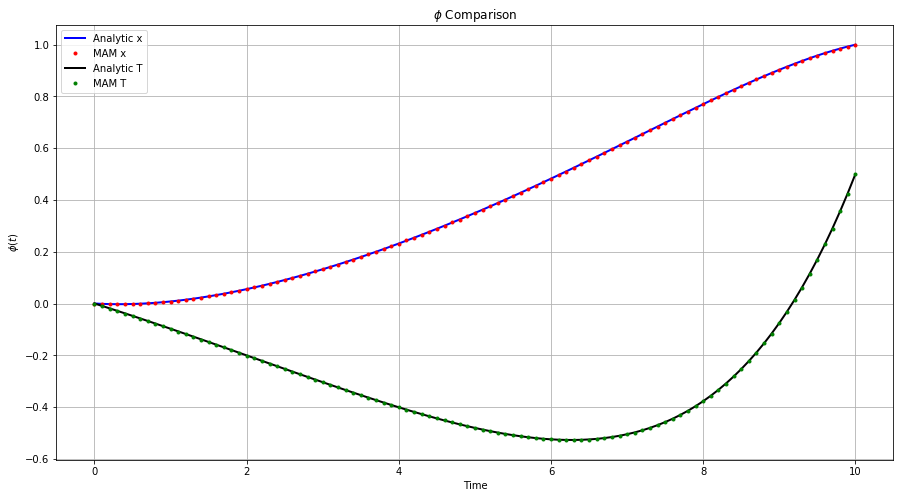

In [49]:
# Comparison Plot

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_title('$\\phi$ Comparison')
ax.plot(time,  analytic_solution[:, 0],'b', linewidth=2, label = 'Analytic x')
ax.plot(time, ou_mam.instanton[:, 0], 'r.', label = 'MAM x')

ax.plot(time,  analytic_solution[:, 1],'k', linewidth=2, label = 'Analytic T')
ax.plot(time, ou_mam.instanton[:, 1], 'g.', label = 'MAM T')

ax.set_xlabel('Time')
ax.set_ylabel('$\\phi(t)$')
ax.legend()
fig.show()

## Calculating action For Nearby Paths

We compare the action for slightly perturb paths, create a histogram and check if our found path does indeed minimise.

In [ ]:
from instanton_utility import *

In [ ]:
# Creating A Load Of Random Paths to compare against

# near_paths = [random_path(ou_mam.instanton, 0.01) for i in range(10000)] # Conclusion Different depending on paths
near_paths = [random_path(ou_mam.instanton, 0.001) for i in range(10000)]

In [ ]:
# Creating Object to Track Action Check

action_track = action_minimisation_checker(drift, ou_mam.instanton, [s, time, Dinv])

In [ ]:
# Doing the Comparison

for path in near_paths:
    action_track.compare(path)

In [ ]:
# Histogram 

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
bins, edges, patches = ax.hist(action_track.av_list, bins=100, density=True)
ax.plot(np.full_like(np.linspace(0, max(bins)), action_track.action_value), 
        np.linspace(0, max(bins)), '--o', label='MAM Instanton')
ax.set_xlabel('Action Value')
ax.set_ylabel('$\\rho$')
ax.set_title('Action Density For Nearby Paths')
ax.legend()
fig.show()

In [ ]:
# Example of perturbed path
# Comparison Plot

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_title('What The Perturbed Paths Look Like')
ax.plot(time,  near_paths[100][:, 0],'b', linewidth=2, label = 'Perturbed Path x')
ax.plot(time, ou_mam.instanton[:, 0], 'r.', label = 'MAM x')

ax.plot(time,  near_paths[100][:, 1],'k', linewidth=2, label = 'Perturbed Path T')
ax.plot(time, ou_mam.instanton[:, 1], 'g.', label = 'MAM T')

ax.set_xlabel('Time')
ax.set_ylabel('$\\phi(t)$')
ax.legend()
fig.show()

## Effect of r

We look at how the difference in noise strength effects the analytic solution.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

for r in tqdm([10**-k for k in range(5)]):
    
    s = [gamma1, gamma2, eps, r]
    a = np.vstack((expA(0, s)[:2], expA(tF, s)[:2]))
    b = np.hstack([initial_point, final_point]) # BCs
    c = la.solve(a, b)
    analytic_solution = np.vstack([np.matmul(expA(t, s), c) for t in time])
    axes[0].plot(time,  analytic_solution[:, 0], label=f'{r:.1e}')
    axes[1].plot(time,  analytic_solution[:, 1], label=f'{r:.1e}')


    
axes[0].legend(title = 'r')
axes[0].grid()
axes[0].set_title('x Convergence Plot')
axes[0].set_ylabel('$x(t)$')
axes[0].set_xlabel('Time')

axes[1].legend(title = 'r')
axes[1].grid()
axes[1].set_title('T Convergence Plot')
axes[1].set_ylabel('$T(t)$')
axes[1].set_xlabel('Time')

fig.show()

## Long Run Save

In [ ]:
# Saving Long Run
import pickle

filename = 'long-run'


# # Save
# # outfile = open(filename,'wb')
# # pickle.dump(result,outfile)
# # outfile.close()

# Load
infile = open(filename,'rb')
long_result = pickle.load(infile)

In [ ]:
long_mam_soln = long_result.x.reshape((100, 2))

s = [gamma1, gamma2, eps, 0.01]
a = np.vstack((expA(0)[:2], expA(tF)[:2]))
b = np.hstack([initial_point, final_point]) # BCs
c = la.solve(a, b)
analytic_solution = np.vstack([np.matmul(expA(t), c) for t in time])

In [ ]:
# Comparison Plot

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_title('$\\phi$ Comparison')
ax.plot(time,  analytic_solution[:, 0],'b', linewidth=2, label = 'Analytic x')
ax.plot(time, long_mam_soln[:, 0], 'r.', label = 'MAM x')

ax.plot(time,  analytic_solution[:, 1],'k', linewidth=2, label = 'Analytic T')
ax.plot(time, long_mam_soln[:, 1], 'g.', label = 'MAM T')

ax.set_xlabel('Time')
ax.set_ylabel('$\\phi(t)$')
ax.legend()
fig.show()

## Big gamma seperation Plot
Parameter choice listed below.

In [ ]:
# bc = [initial_point, final_point]
# save_result(result, [s, bc, time], 'Gamma-Run')

In [ ]:
# Loading result
result, s, bc, time = load_result('Gamma-Run')

In [ ]:
# Unpacking Load

initial_point = bc[0]
final_point = bc[1]
t0 = time[0]
tF = time[-1]
mam_result = result.x.reshape((100, 2))

# Solving Linear System arising from Boundary Conditions
# a * c = b

a = np.vstack((expA(t0, s)[:2], expA(tF, s)[:2]))
b = np.hstack([initial_point, final_point]) # BCs
c = la.solve(a, b)
print(f'c = {c}')

analytic_solution = np.vstack([np.matmul(expA(t, p=s), c) for t in time])

In [ ]:
# Comparison Plot

fig, ax = plt.subplots(figsize=(15, 8))

ax.grid()
ax.set_title('$\\phi$ Comparison')
ax.plot(time,  analytic_solution[:, 0],'b', linewidth=2, label = 'Analytic x')
ax.plot(time, mam_result[:, 0], 'r.', label = 'MAM x')

ax.plot(time,  analytic_solution[:, 1],'k', linewidth=2, label = 'Analytic T')
ax.plot(time, mam_result[:, 1], 'g.', label = 'MAM T')

ax.set_xlabel('Time')
ax.set_ylabel('$\\phi(t)$')
ax.legend()
fig.show()